# Project: Predict Future Sales
#### Notebook 3 of 4: bottom level feature engineering and modeling

#### In this notebook, we mainly did the following for bottom level data:
- feature engineering
- data pre-preparation
- Modelling
- Analyse shap values of one model



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


import matplotlib
from matplotlib import pyplot as plt
from textwrap import wrap


pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None 

import pickle
import time
from tqdm import tqdm

import lightgbm as lgb

from itertools import product

random_key=42

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit


from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.ensemble import StackingRegressor
import shap

from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
# The function will:
# 1. run the input HalvingGridSearchCV
# 2. compute and compare the rmse for training data and testing data
# 3. plot feature importance list

def run_model(model, model_name, X_train, y_train, X_validation, y_validation, fit_params=None):
   
    # run the input GridSearchCV
    if fit_params == None:
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train, **fit_params)
    
    # print(gs.best_params_)
    if isinstance(model, HalvingGridSearchCV) or isinstance(model, GridSearchCV) :
        print("best_params: ")
       # print(gs.best_params_, best_lgb.best_score_)
        for (item, value) in model.best_params_.items():
            print('   ',item, ' : ', value)
    
     # Get predictions
    y_train_preds = model.predict(X_train) 
    y_validation_preds = model.predict(X_validation)
    
    #compute and compare the rmse for training data and testing data
    train_rmse_score =  mean_squared_error(y_train, y_train_preds,squared=False)
    validation_rmse_score = mean_squared_error(y_validation, y_validation_preds,squared=False)
    rmse_perc_diff = np.abs(validation_rmse_score/train_rmse_score*100-100)
    
    print(f'\nrmse_score on training set: {train_rmse_score:.3f}')
    print(f'rmse_score on validation set: {validation_rmse_score:.3f}')
    print(f'perc_diff: {rmse_perc_diff:.1f} %\n')
    
   
    
    # only plot the important feature list if the model is instance of (gridsearchcv)
    if isinstance(model,HalvingGridSearchCV) or isinstance(model, GridSearchCV):
        # plot featureimportances
        #model = gs.best_estimator_.named_steps["classifier"]
        model_ = model.best_estimator_
        if not isinstance(model_,StackingRegressor): 
            importances = model_.feature_importances_
            indices = np.argsort(importances)
            fig,ax=plt.subplots(1,figsize=(7,20))
            features = X_train.columns
            plt.title('Feature Importance')
            ax.barh(range(len(indices)), importances[indices], color='b', align='center')
            plt.yticks(range(len(indices)), [features[i] for i in indices])
            plt.xlabel('Relative Importance')
            plt.show()

    
    
    

    return pd.DataFrame({'rmse_score on training set': train_rmse_score,
                         'rmse_score on testing set': validation_rmse_score,
                         'Generalization %': rmse_perc_diff,
                        }, index=[model_name])

In [3]:
#the function is to create new lag features
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    new_feature_list=[]
    for i in lags:
        shifted = tmp.copy()
        new_feature = col+'_lag_'+str(i)
        new_feature_list.append( new_feature)
        shifted.columns = ['date_block_num','shop_id','item_id',new_feature ]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df,new_feature_list

# import data from pickle file

In [4]:
#read pickle_dict, which store everything

pickle_dict1 = pickle.load(open('../temp/data1.pkl', 'rb'))
df_all = pickle_dict1['df_all']   #concat df_train_m and df_test
df_train = pickle_dict1['df_train']
df_test = pickle_dict1['df_test']
df_items = pickle_dict1['df_items']
df_shops = pickle_dict1['df_shops']
df_cat = pickle_dict1['df_cat']
new_arrival_item_list = pickle_dict1['new_arrival_item_list']


pickle_dict2 = pickle.load(open('../temp/data2.pkl', 'rb'))
df_basegrid = pickle_dict2['df_basegrid']   #concat df_train_m and df_test


# Feature Engineering

In [8]:
df_temp = df_basegrid


#feature engineerinf flag, it controls which featurs to be added to final feature list
fe_flag=[ 1, #0, item name
          1, #1, item category name
          1, #2, shop name
          0, #3, release month of item in the shop
          1, #4, lagged item_cnt_month
          1, #5, lagged monthly all-shop sales for each item
          0, #6, Number of month from last sale of shop/item (Use info from past)
          1, #7, lag shop cat  
          1, #8, lag cat monthly sale
          1, #9, lag price
]

#hold the features to be added to final selection
list_new_features = []

# Some parameters(maybe add more periods, score will be better) [1,2,3,12]
lookback_range = [1,2,3,4,5]


In [9]:
############################ 0 item name feature engineering: tfidfvectorize item_name
##################################################################
if fe_flag[0] == 1:    
    items_subset = df_items[['item_id', 'item_name']]
    feature_count = 15
    tfidf = TfidfVectorizer(max_features=feature_count)
    items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_subset['item_name']).toarray())

    cols = items_df_item_name_text_features.columns
    for i in range(feature_count):
        feature_name = 'item_name_tfidf_' + str(i)
        items_subset[feature_name] = items_df_item_name_text_features[cols[i]]
        list_new_features.append(feature_name)

    items_subset.drop('item_name', axis = 1, inplace = True)
    df_temp = df_temp.merge(items_subset, on = 'item_id', how = 'left')
    df_temp.head()


In [11]:
############################## 1 item category feature engineering: tfidfvectorize item_category_name
#####################################################################
if fe_flag[1] == 1:   
    cat_subset = df_cat[['item_category_id', 'item_category_name']]
    feature_count = 15
    tfidf = TfidfVectorizer(max_features=feature_count)
    df_cat_name_text_features = pd.DataFrame(tfidf.fit_transform(cat_subset['item_category_name']).toarray())

    cols = df_cat_name_text_features.columns
    for i in range(feature_count):
        feature_name = 'cat_name_tfidf_' + str(i)
        cat_subset[feature_name] = df_cat_name_text_features[cols[i]]
        list_new_features.append(feature_name)

    cat_subset.drop('item_category_name', axis = 1, inplace = True)
    df_temp = df_temp.merge(cat_subset, on = 'item_category_id', how = 'left')
    df_temp.head()




In [13]:
########################## 2 shop feature engineering: tfidfvectorize shop_name
###################################################################
if fe_flag[2] == 1:
    shop_subset = df_shops[['shop_id', 'shop_name']]
    feature_count = 15
    tfidf = TfidfVectorizer(max_features=feature_count)
    df_shop_name_text_features = pd.DataFrame(tfidf.fit_transform(shop_subset['shop_name']).toarray())

    cols = df_shop_name_text_features.columns
    for i in range(feature_count):
        feature_name = 'shop_name_tfidf_' + str(i)
        shop_subset.loc[:, feature_name] = df_shop_name_text_features[cols[i]]
        list_new_features.append(feature_name)

    shop_subset.drop('shop_name', axis = 1, inplace = True)
    df_temp = df_temp.merge(shop_subset, on = 'shop_id', how = 'left')
    df_temp.head()

In [14]:
############################# 3 release month of item in the shop
#####################################################################
if fe_flag[3] == 1:
    list_feature_shop_name=[]
    df_temp =df_temp.merge(df_shops, on='shop_id')
    list_feature_shop_name=['shop_name']
    dict_final_selected_features[2]=list_feature_shop_name



In [15]:
############################### 4 lagged item_cnt_month
######################################################################
if fe_flag[4] == 1:
    for diff in tqdm(lookback_range):
        feature_name = 'mnthly_sales_of_the_item_in_the_shop_lag_' + str(diff)
        trainset2 = df_temp.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        df_temp = df_temp.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        df_temp[feature_name] = df_temp[feature_name].fillna(0)
        list_new_features.append(feature_name)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.63s/it]


In [16]:
############################# 5 lagged monthly all-shop sales for each item
######################################################################
if fe_flag[5] == 1:
    groups = df_temp.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'mnthly_sales_of_the_item_in_all_shops_lag_' + str(diff)
        result = groups.agg({'item_cnt_month':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        df_temp = df_temp.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        df_temp[feature_name] = df_temp[feature_name].fillna(0)
        list_new_features.append(feature_name)      


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]


In [17]:
############################# 6 Number of month from last sale of shop/item (Use info from past)
######################################################################
def create_last_sale_shop_item(row):
    for diff in range(1,33+1):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        if row[feature_name] != 0.0:
            return diff
    return np.nan

    lookback_range = list(range(1, 33 + 1))
    for diff in tqdm(lookback_range):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        trainset2 = df_temp.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        df_temp = df_temp.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        df_temp[feature_name] = df_temp[feature_name].fillna(0)
            #new_features.append(feature_name)

    df_temp.loc[:, 'last_sale_shop_item'] = df_temp.apply (lambda row: create_last_sale_shop_item(row),axis=1)
    list_new_features.append('last_sale_shop_item')


In [18]:
#####################  7 lagged shop-cat
#################################################################
if fe_flag[7] == 1:
    group = df_temp.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
    group.columns = ['mnthly_sales_of_the_cat_in_the_shop']
    group.reset_index(inplace=True)

    df_temp = pd.merge(df_temp, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
    df_temp['mnthly_sales_of_the_cat_in_the_shop'] = df_temp['mnthly_sales_of_the_cat_in_the_shop'].astype(np.float16)
    df_temp, new_features = lag_feature(df_temp, [1,2,3,6], 'mnthly_sales_of_the_cat_in_the_shop')
    df_temp.drop(['mnthly_sales_of_the_cat_in_the_shop'], axis=1, inplace=True)
    list_new_features +=new_features

In [19]:
################# 8 lagged cat monthly sale
#################################################
if fe_flag[8] == 1:
    group = df_temp.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
    group.columns = [ 'mnthly_sales_of_the_cat_in_all_shops' ]
    group.reset_index(inplace=True)

    df_temp = pd.merge(df_temp, group, on=['date_block_num','item_category_id'], how='left')
    df_temp['mnthly_sales_of_the_cat_in_all_shops'] = df_temp['mnthly_sales_of_the_cat_in_all_shops'].astype(np.float16)
    df_temp, new_features = lag_feature(df_temp, [1,2,3], 'mnthly_sales_of_the_cat_in_all_shops')
    df_temp.drop(['mnthly_sales_of_the_cat_in_all_shops'], axis=1, inplace=True)
    list_new_features +=new_features



In [20]:
################# 9 lagged item_price
#################################################
if fe_flag[9] == 1:
    groups = df_temp.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'item_price_lag_' + str(diff)
        result = groups.agg({'item_price':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_price': feature_name}, inplace=True)
        df_temp = df_temp.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        df_temp[feature_name] = df_temp[feature_name]
        df_temp[feature_name] = df_temp[feature_name].fillna(0)
        list_new_features.append(feature_name)      
    

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


In [21]:
##########fill all null values with 0
###################################################
df_temp = df_temp.fillna(0)

df_temp.isnull().sum()

shop_id                                        0
item_id                                        0
date_block_num                                 0
item_price                                     0
item_cnt_month                                 0
is_new_arrival                                 0
month                                          0
year                                           0
year_month                                     0
item_category_id                               0
item_name_tfidf_0                              0
item_name_tfidf_1                              0
item_name_tfidf_2                              0
item_name_tfidf_3                              0
item_name_tfidf_4                              0
item_name_tfidf_5                              0
item_name_tfidf_6                              0
item_name_tfidf_7                              0
item_name_tfidf_8                              0
item_name_tfidf_9                              0
item_name_tfidf_10  

# data pre-preparation

In [22]:

list_feature_base = ['shop_id','item_id', 'item_category_id','date_block_num',
                     'month','year','is_new_arrival', 
                     'item_cnt_month'
                 ]

list_feature_final =   list_new_features + list_feature_base
#print(list_feature_final)


df_final = df_temp[list_feature_final]

#Remove data for the first three months
#df_final= df_final[(df_final['date_block_num'] > 2)]


validation_date_block_num= 33   #'1-10-2015'
test_date_block_num = 34        #'1-11-2015'


index_train = (df_final['date_block_num'] < validation_date_block_num)
df_train_final = df_final[index_train]

index_validation = (df_final['date_block_num'] == validation_date_block_num)
df_validation_final = df_final[index_validation]


index_test = (df_final['date_block_num'] == test_date_block_num)
df_test_final = df_final[index_test]



X_train =  df_train_final.iloc[:, 0:-1]
y_train =  df_train_final.iloc[:, -1]
print('\nprinting X_train.columns')
print(X_train.columns)

print('\nprinting y_train.info()')
print(y_train.info())

X_validation = df_validation_final.iloc[:, 0:-1]
y_validation =  df_validation_final.iloc[:, -1]

X_test =  df_test_final.iloc[:, 0:-1]
y_test =  df_test_final.iloc[:, -1]


####TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2, test_size=1)


# result_list to hold the result from each model for final evaluation
result_list = []


printing X_train.columns
Index(['item_name_tfidf_0', 'item_name_tfidf_1', 'item_name_tfidf_2',
       'item_name_tfidf_3', 'item_name_tfidf_4', 'item_name_tfidf_5',
       'item_name_tfidf_6', 'item_name_tfidf_7', 'item_name_tfidf_8',
       'item_name_tfidf_9', 'item_name_tfidf_10', 'item_name_tfidf_11',
       'item_name_tfidf_12', 'item_name_tfidf_13', 'item_name_tfidf_14',
       'cat_name_tfidf_0', 'cat_name_tfidf_1', 'cat_name_tfidf_2',
       'cat_name_tfidf_3', 'cat_name_tfidf_4', 'cat_name_tfidf_5',
       'cat_name_tfidf_6', 'cat_name_tfidf_7', 'cat_name_tfidf_8',
       'cat_name_tfidf_9', 'cat_name_tfidf_10', 'cat_name_tfidf_11',
       'cat_name_tfidf_12', 'cat_name_tfidf_13', 'cat_name_tfidf_14',
       'shop_name_tfidf_0', 'shop_name_tfidf_1', 'shop_name_tfidf_2',
       'shop_name_tfidf_3', 'shop_name_tfidf_4', 'shop_name_tfidf_5',
       'shop_name_tfidf_6', 'shop_name_tfidf_7', 'shop_name_tfidf_8',
       'shop_name_tfidf_9', 'shop_name_tfidf_10', 'shop_name_tfidf_11

# Modelling

#### Model: LGBMRegressor
- Kaggle Score: 0.94407,  after reconciliation, Score: 0.93976

[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
best_params: 
    lambda_l2  :  0
    max_depth  :  8
    reg_alpha  :  0.5

rmse_score on training set: 1.083
rmse_score on validation set: 0.927
perc_diff: 14.4 %



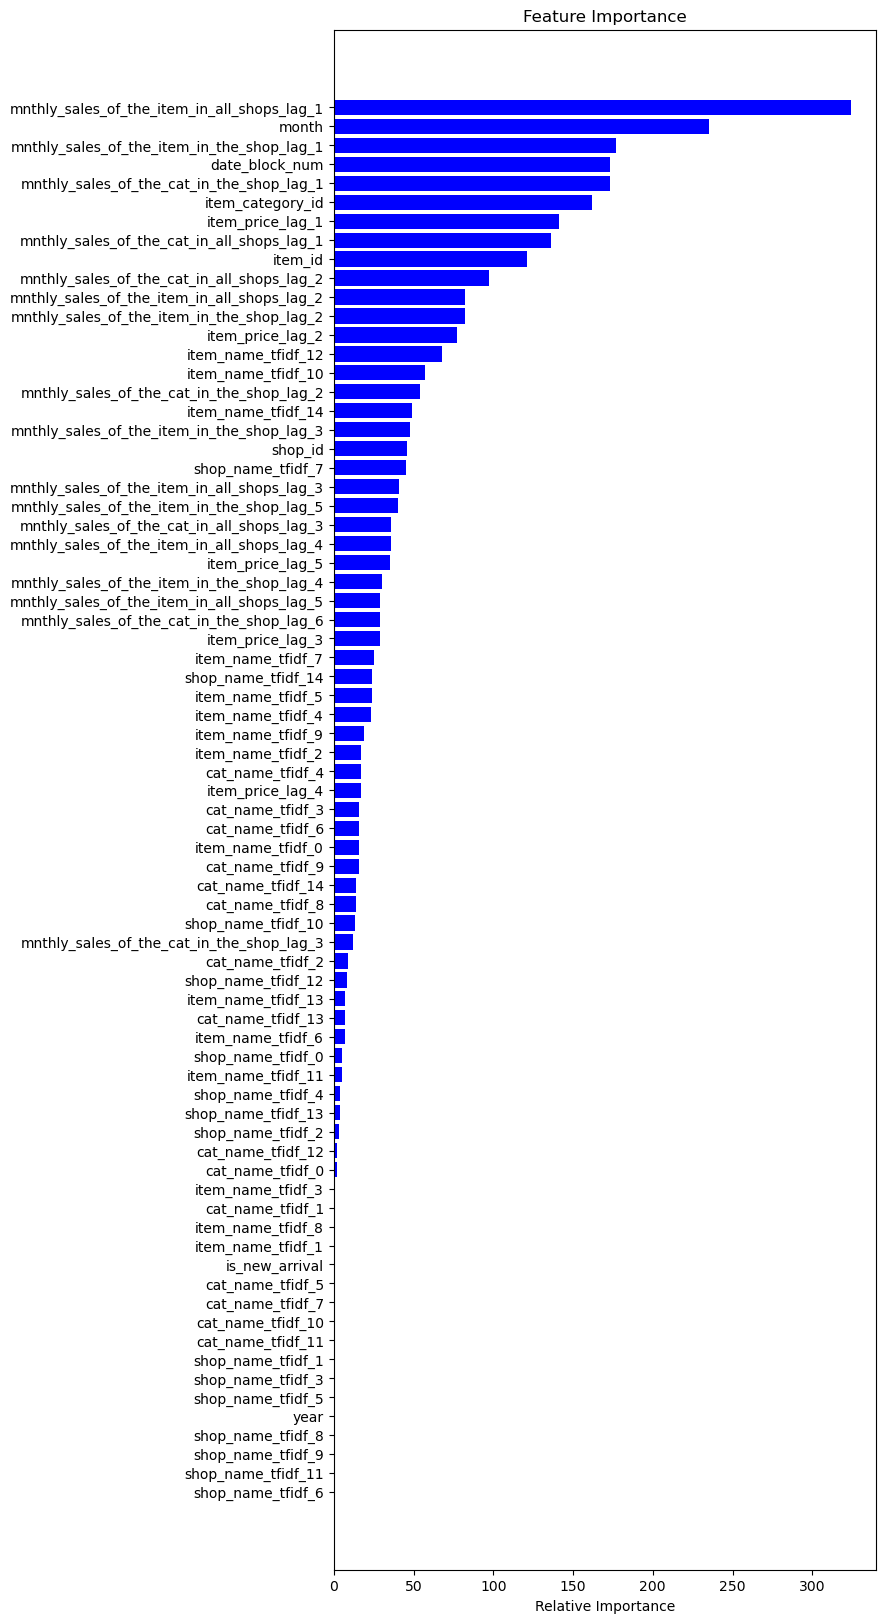

Wall time: 5min 24s


In [23]:
%%time
param_grid = {
    #'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
   # 'min_data_in_leaf': [400, 1000],
    'max_depth':[6, 8, 10],
    #'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

hgs_lgb = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=random_key), 
                      param_grid=param_grid,
                      scoring = 'neg_root_mean_squared_error',
                      cv=tscv,
                      n_jobs = 3,
                     # random_state = random_key+1
                    
                     )

result = run_model(hgs_lgb, 'LightGBM', X_train, y_train, X_validation, y_validation)
result_list.append(result)
best_lgb = hgs_lgb.best_estimator_

### Model: XGBRegressor

- Kaggle Score: 0.96352

Fitting 2 folds for each of 8 candidates, totalling 16 fits
best_params: 
    learning_rate  :  0.1
    max_depth  :  8
    n_estimators  :  500

rmse_score on training set: 0.966
rmse_score on validation set: 0.936
perc_diff: 3.1 %



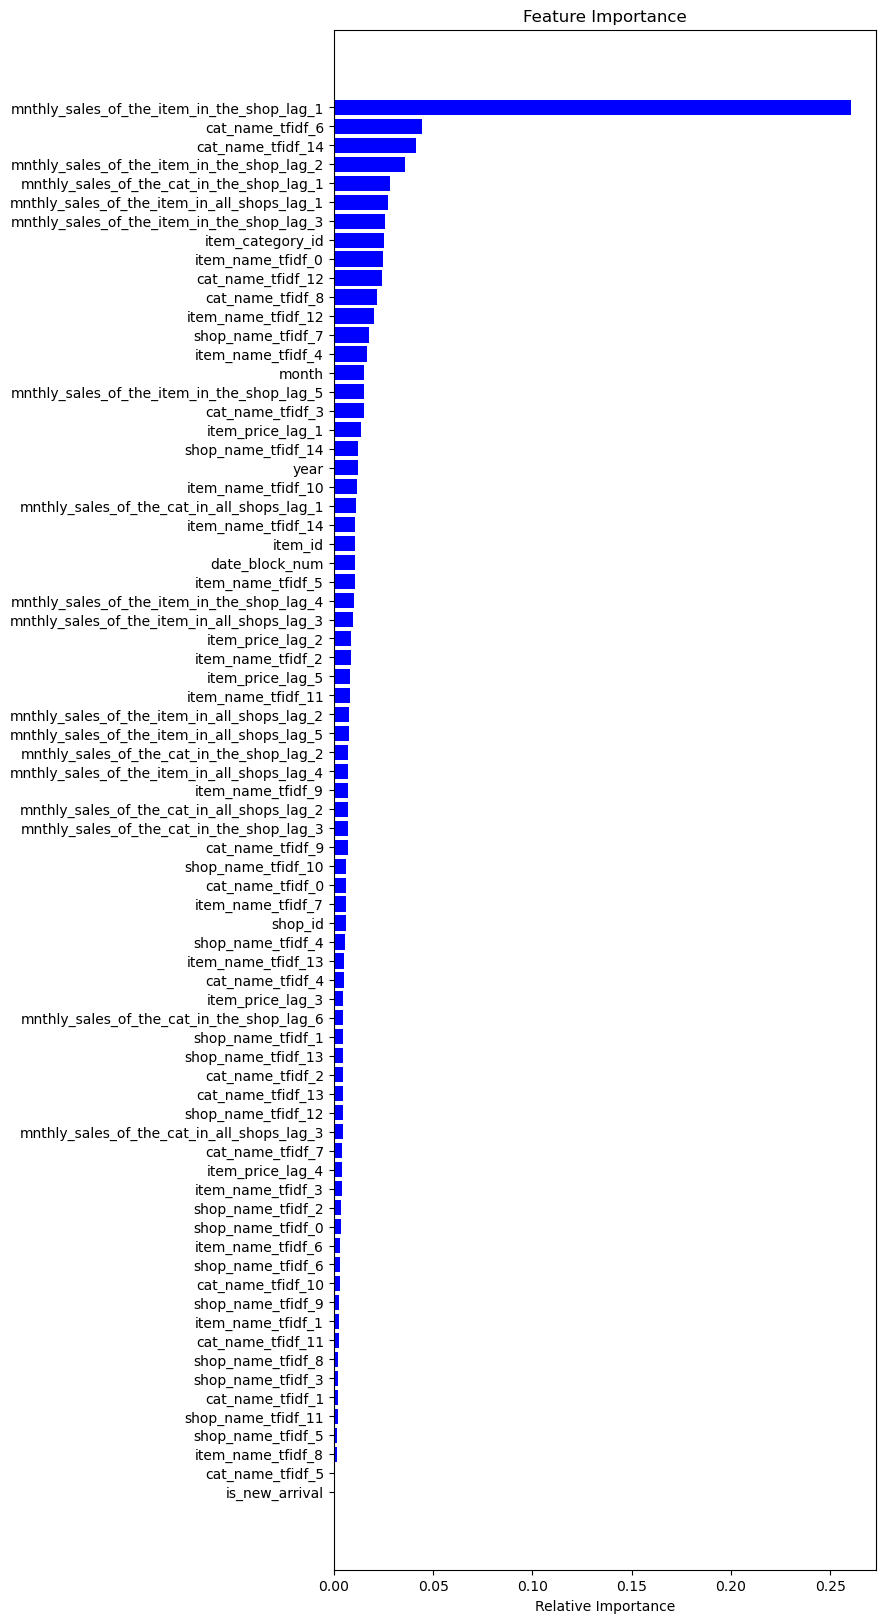

Wall time: 16min 43s


In [24]:
%%time


xgb_reg = xgb.XGBRegressor(
    #max_depth=8,
    tree_method = 'hist',
    n_estimators=100,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=random_key,
   # early_stopping_rounds=5,
   # eval_metric = 'rmse' 
)


param_grid = {"learning_rate": (0.1, 0.3),
              "max_depth": [5, 8],
              'n_estimators': [100, 500]
              #"min_child_weight": [ 1, 5],
              #"gamma":[ 0.0, 0.2],
              # "colsample_bytree":[ 0.3, 0.4]
             }

fit_params={#"early_stopping_rounds":5, 
            #"eval_metric" : "rmse", 
            "eval_set" : [[X_validation, y_validation]]
           }



hgs_xgb = GridSearchCV(estimator=xgb_reg, 
                      param_grid=param_grid,
                      scoring = 'neg_root_mean_squared_error',
                      cv=tscv,
                      n_jobs = 3,
                      #random_state = random_key,
                      verbose = 10
                     )

result = run_model(hgs_xgb, 'XGBRegressor', X_train, y_train, X_validation, y_validation, 
                  # fit_params 
                  )
result_list.append(result)
best_xgb = hgs_xgb.best_estimator_



### Model: ensemble
- Score: 0.94510

In [25]:
from sklearn.linear_model import LinearRegression


estimators = [('lgb', best_lgb),('xgb', best_xgb) ]


stack_reg = StackingRegressor(
                        estimators=estimators,
                        final_estimator=LinearRegression()
)



result = run_model(stack_reg, 'StackingRegressor', X_train, y_train, X_validation, y_validation)
result_list.append(result)
best_stack_reg = stack_reg


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0

rmse_score on training set: 0.995
rmse_score on validation set: 0.924
perc_diff: 7.2 %



# Model Evaluation

In [26]:
# Table of evalution metrics from all the models
result_final = pd.concat(result_list, axis=0)
result_final

,rmse_score on training set,rmse_score on testing set,Generalization %
LightGBM,1.08,0.93,14.38
XGBRegressor,0.97,0.94,3.10
StackingRegressor,0.99,0.92,7.17


**Observations**
- all models have similar performance at test set
- StackingRegressor is chosen as prodcution model due to its good rmse score and generalization

# production model and make predictions

In [35]:
#production_model = best_lgb

#production_model = best_xgb
production_model = best_stack_reg

#### Shap values of model "lightGBM"

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


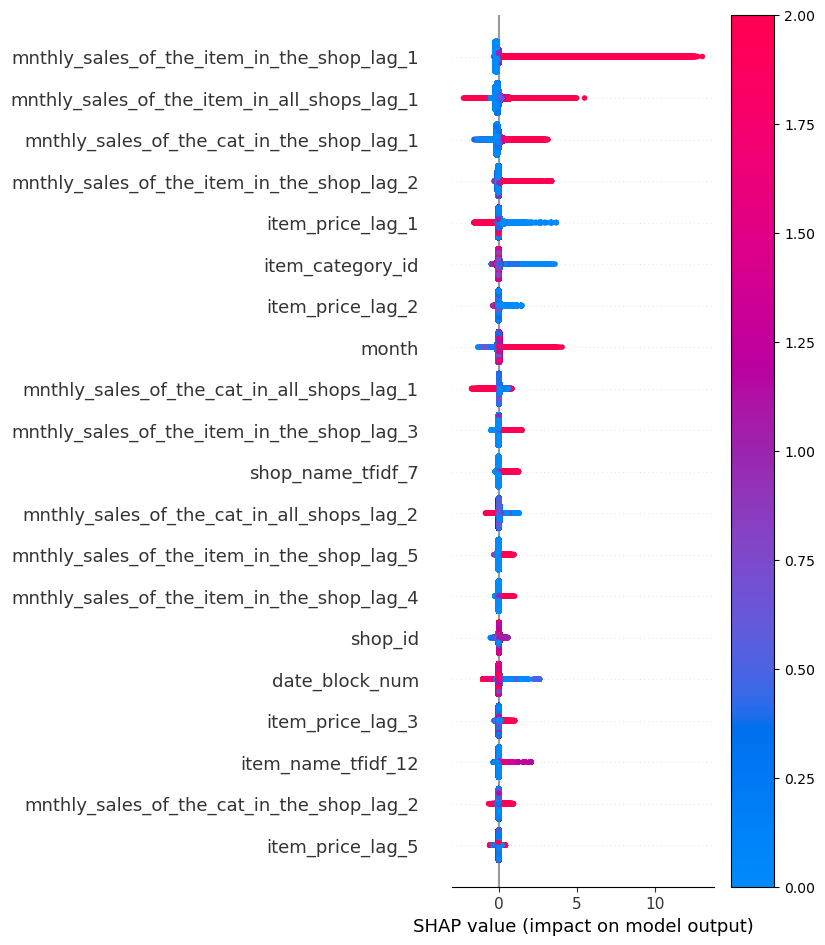

Wall time: 12min 34s


In [28]:
%%time
shap_values = shap.TreeExplainer(production_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train,show=False, color_bar=False)
plt.colorbar()
plt.show()


**Observations**
- Shapley value: the average of the marginal contributions of a feature across all permutations
- Most important features: 
    - Previous monthly sales of the product in the shop
    - Previous monthly sales of the product in all shops
    - Previous monthly sales of the product category in the shop



# pickle test_preds for model reconciliation

In [36]:
df_test_preds = df_test_final
df_test_preds['item_cnt_month'] = production_model.predict(X_test)

pickle_dict_preds = dict()
pickle_dict_preds['df_test_preds']=df_test_preds
pickle.dump(pickle_dict_preds, open(f'../temp/df_test_preds.pkl', 'wb'))

pickle_dict_preds['df_test_preds'].head()

,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,cat_name_tfidf_0,cat_name_tfidf_1,cat_name_tfidf_2,cat_name_tfidf_3,cat_name_tfidf_4,cat_name_tfidf_5,cat_name_tfidf_6,cat_name_tfidf_7,cat_name_tfidf_8,cat_name_tfidf_9,cat_name_tfidf_10,cat_name_tfidf_11,cat_name_tfidf_12,cat_name_tfidf_13,cat_name_tfidf_14,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,mnthly_sales_of_the_item_in_the_shop_lag_1,mnthly_sales_of_the_item_in_the_shop_lag_2,mnthly_sales_of_the_item_in_the_shop_lag_3,mnthly_sales_of_the_item_in_the_shop_lag_4,mnthly_sales_of_the_item_in_the_shop_lag_5,mnthly_sales_of_the_item_in_all_shops_lag_1,mnthly_sales_of_the_item_in_all_shops_lag_2,mnthly_sales_of_the_item_in_all_shops_lag_3,mnthly_sales_of_the_item_in_all_shops_lag_4,mnthly_sales_of_the_item_in_all_shops_lag_5,mnthly_sales_of_the_cat_in_the_shop_lag_1,mnthly_sales_of_the_cat_in_the_shop_lag_2,mnthly_sales_of_the_cat_in_the_shop_lag_3,mnthly_sales_of_the_cat_in_the_shop_lag_6,mnthly_sales_of_the_cat_in_all_shops_lag_1,mnthly_sales_of_the_cat_in_all_shops_lag_2,mnthly_sales_of_the_cat_in_all_shops_lag_3,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_4,item_price_lag_5,shop_id,item_id,item_category_id,date_block_num,month,year,is_new_arrival,item_cnt_month
2738805,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.44,0.00,0.00,0.00,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,5441,0,34,11,2015,1,2.33
2738806,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.44,0.00,0.00,0.00,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67,0.68,1.83,1.22,0.90,0.00,0.00,0.00,0.17,0.23,0.23,0.36,"1,331.67","1,429.51","1,587.19","1,518.58","1,304.37",2,5643,2,34,11,2015,0,0.08
2738807,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.69,0.00,0.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.44,0.00,0.00,0.00,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67,0.68,0.61,0.20,0.00,0.00,0.00,0.00,0.00,0.23,0.23,0.36,"1,246.42","1,343.66","1,016.34",413.41,0.00,2,13411,2,34,11,2015,0,0.32
2738808,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.44,0.00,0.00,0.00,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.15,0.05,0.27,0.44,0.00,0.00,0.00,0.17,0.23,0.23,0.36,156.67,481.46,160.49,691.59,"1,043.16",2,5634,2,34,11,2015,0,-0.10
2738809,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.44,0.00,0.00,0.00,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.02,0.07,0.10,0.24,0.20,0.00,0.00,0.00,0.17,0.23,0.23,0.36,78.33,240.73,299.19,802.44,641.95,2,5638,2,34,11,2015,0,-0.31


# Submission

In [32]:

#calculate y_test and submit
df_test_final['item_cnt_month'] = production_model.predict(X_test).clip(0,20)






df_submission = df_test_final.merge(df_test, on=['shop_id', 'item_id'])[["ID", "item_cnt_month"]]
df_submission.set_index('ID',drop=False, inplace=True)
df_submission.sort_index(inplace=True)

df_submission.to_csv("../datasets/submission.csv", index=False)
df_submission.head()

,ID,item_cnt_month
ID,,
0,0,0.57
1,1,0.32
2,2,1.11
3,3,0.50
4,4,4.41
